In [1]:
import numpy as np
import pandas as pd

import pickle

from tqdm.auto import tqdm

import cv2

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

from torchvision import models

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt

In [2]:
class helper():
    def __init__(self):
        pass
    
    def get_img(im_path):
        tfms = A.Compose([A.Normalize(mean = 0.0, std = 1.0),
                  ToTensorV2()])
        img = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)
        img = tfms(image = img)['image']
        return img
    
    def get_heatmap(img, model):
        model.eval()
        pred = model(torch.unsqueeze(img.cuda(), axis = 0))
        out = int(pred.argmax(dim = -1).cpu().numpy())
        pred[:, out].backward()
        gradients = model.get_gradient()
        pooled_gradients = torch.mean(gradients, dim = [0, 2, 3])
        activations = model.get_activations(torch.unsqueeze(img.cuda(), axis = 0)).detach()
        for i in range(512):
            activations[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu().numpy(), 0)
        heatmap /= np.max(heatmap)
        plt.figure(figsize = (25, 25))
        plt.subplot(5, 5, 1, xticks = [], yticks = [])
        plt.imshow(img.permute(1, 2, 0).numpy())
        title = plt.title('Input Image')
        plt.setp(title, color = 'green')
        plt.subplot(5, 5, 2, xticks = [], yticks = [])
        plt.imshow(cv2.resize(heatmap, (320, 320)), cmap = 'jet')
        title = plt.title('Extracted Features')
        plt.setp(title, color = 'green')
        plt.subplot(5, 5, 3, xticks = [], yticks = [])
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.imshow(cv2.resize(heatmap, (320, 320)), cmap = 'jet', alpha = 0.55)
        title = plt.title(f'Category — {out + 1} Cyclone')
        plt.setp(title, color = 'green')

In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = models.resnet18()
        self.features = nn.Sequential(self.model.conv1,
                                      self.model.bn1,
                                      self.model.relu,
                                      self.model.maxpool,
                                      self.model.layer1,
                                      self.model.layer2,
                                      self.model.layer3,
                                      self.model.layer4)
        self.avgpool = self.model.avgpool
        self.fc = nn.Sequential(nn.Linear(in_features = 512, out_features = 256),
                                nn.BatchNorm1d(256),
                                nn.ReLU(),
                                nn.Linear(in_features = 256, out_features = 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(in_features = 128, out_features = 4),
                                nn.Softmax(dim = -1))
        self.gradients = None
        
    def activations_hook(self, grad):
        self.gradients = grad
        
    def get_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [4]:
if torch.cuda.is_available():
    DEVICE = "cuda:0"
    torch.cuda.empty_cache()
else:
    DEVICE = "cpu"
    
model = Network()
model = model.to(DEVICE)
model.load_state_dict(torch.load('../input/cyclone-model/ResNet18_0.001_CosineAnnealing_AMP.pth'))

<All keys matched successfully>

In [5]:
df = pd.read_csv('../input/cyclones/Folds/MIR/Folds_1/train.csv')

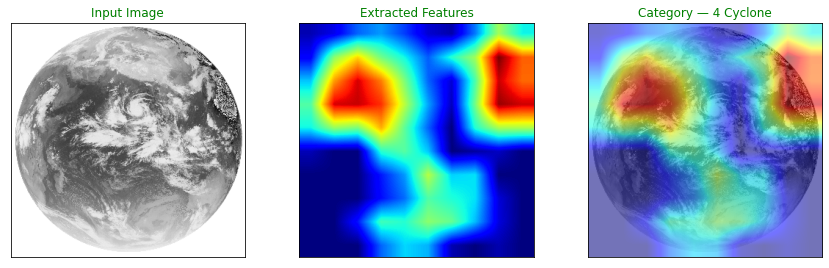

In [16]:
idx = 415
img = helper.get_img(df.Image[idx])
helper.get_heatmap(img, model)